In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
import seaborn as sns
from sys import path
from glob import glob

from chemulator import Chemulator


# Initializing the Emulator

Chemulator has a simple initialization function that simple takes the path the directory where a chemical encoder is stored. In this case, we'll point it to the autoencoder from the Holdship et al. 2021 release paper.

The resulting emulator object can either be used to create a whole new emulator of the ```load_model``` function can be used to load a pre-trained model/ensemble. Here, we'll use the emulator used for the performance metrics of the release paper.

In [10]:
autoencoder_dir="../models/autoencoder-2021-release/"
emulator=Chemulator(autoencoder_dir)
emulator.load_model("../models/emulator-2021-release/")

This emulator is now ready to use!
Below we'll demonstrate the model in use

# Time Dependence

We'll first demonstrate the emulator's use on some of the test data from the training. Note that other than "Time" and "model", all columns in this first example are required to run the emulator.

In [86]:
input_data=pd.read_hdf("example_models.hdf",key="df").reset_index(drop=True)

In [98]:
#pick a random model
start_time=1000
i=input_data[(input_data["Time"]==start_time)].index
i=np.random.choice(i)


#use the emulator's prepare inputs function to scale all the data and encode chemistry
model_df=emulator.prepare_inputs(input_data.loc[i:i].reset_index(drop=True),learn_scaling=False)

In [99]:
#now here we loop over the number of timesteps to reach the end of the example model
steps_til_end=int((1e6-start_time)/1000.0)-1
outputs=pd.DataFrame()
for step in range(steps_til_end):
    output=emulator.predict_multiple_timesteps(model_df,1)
    outputs=outputs.append(output,sort=False)
    model_df["gas_temp"]=output["gas_temp"]
    model_df[emulator.chem_labels]=output[emulator.chem_labels]

Note we could have used emulator.predict_multiple_timesteps(model_df,1000) if we wanted to skip to 1 Myr in one go.

Below we return to unscaled variables and real chemistry before plotting against the real data to see how the emulator holds up.

In [100]:
#get unscaled predictions
predicted=emulator.recover_real_values(outputs)

#grab the real data to compare
models=input_data.loc[i:i+998]

In [101]:
i

7002

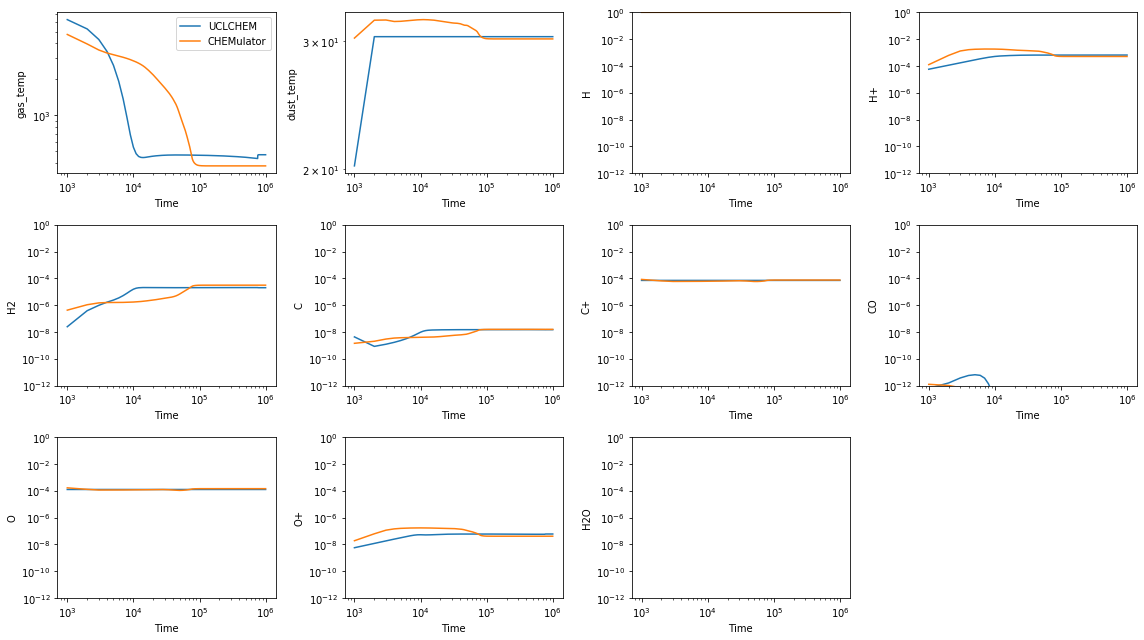

In [104]:
plot_specs=["gas_temp","dust_temp","H","H+","H2","C","C+","CO","O","O+","H2O"]
fig,axes=plt.subplots(3,4,tight_layout=True,figsize=(16,9))
times=[start_time+(1000*i+1) for i in range(steps_til_end)]
axes=axes.flatten()
for i,ax in enumerate(axes[:-1]):
    ax.plot(models["Time"],models[plot_specs[i]],label="UCLCHEM")
    ax.plot(times,predicted[plot_specs[i]],label="CHEMulator")
    ax.set(xscale="log",yscale="log",xlabel="Time",ylabel=plot_specs[i])
    if i >1:
        ax.set(ylim=(1e-12,1))
axes[0].legend()
axes[-1].remove()

# Comparison to UCLPDR

Here we replicate Fig 2. of the release paper but using Chemulator instead of UCLCHEM.

More importantly, this serves as an example for how to initialize your own model.

In [37]:
model_df=pd.read_csv("sine_input.csv")


In [38]:
model_df

,Particle,T_g,n_H,H2_abun,C_abun,FUV,x,delta_x,delta_h2_col,delta_c_col,delta_col_dens,total_h2_col,total_c_col,total_col_dens,size
0,1,100.9120,52570.5,0.006470,1.676530e-06,9.99984,-3.180156e+19,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,16,102.7800,75087.7,0.050528,2.396100e-06,9.99984,-3.180156e+19,2.000000e+10,7.588078e+13,3.598353e+09,1.501754e+15,4.358194e+14,4.665551e+10,2.376777e+16,3.900000e+11
2,31,86.2791,92354.0,0.328082,3.635100e-06,9.99984,-3.180156e+19,9.999999e+09,3.029968e+14,3.357160e+09,9.235399e+14,4.352329e+15,1.061395e+11,4.331426e+16,6.200000e+11
3,46,74.5608,100606.0,0.421634,4.406570e-06,9.99984,-3.180156e+19,9.999999e+09,4.241891e+14,4.433273e+09,1.006060e+15,1.352157e+16,2.024797e+11,6.671263e+16,8.600000e+11
4,61,71.0860,98044.0,0.439261,4.455190e-06,9.99984,-3.180156e+19,2.000000e+10,8.613380e+14,8.736092e+09,1.960880e+15,2.393420e+16,3.103052e+11,9.075010e+16,1.100000e+12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,1381,16.8962,22895.8,0.499970,8.677700e-09,9.99984,3.180156e+19,2.000000e+10,2.289443e+14,3.973658e+06,4.579160e+14,1.026692e+24,3.592001e+17,2.053494e+24,6.360312e+19
93,1396,16.5534,44733.3,0.499982,3.891400e-09,9.99984,3.180156e+19,2.000000e+10,4.473169e+14,3.481504e+06,8.946661e+14,1.026692e+24,3.592001e+17,2.053494e+24,6.360312e+19
94,1411,14.7481,67936.9,0.499986,2.323510e-09,9.99984,3.180156e+19,2.000000e+10,6.793500e+14,3.157042e+06,1.358738e+15,1.026692e+24,3.592001e+17,2.053494e+24,6.360312e+19
95,1426,13.8569,87448.4,0.499988,1.709610e-09,9.99984,3.180156e+19,9.999999e+09,4.372315e+14,1.495026e+06,8.744839e+14,1.026692e+24,3.592001e+17,2.053494e+24,6.360312e+19


In [41]:
#this is a file with all the input column densities and the total UV
model_df=pd.read_csv("sine_input.csv")

#We're subsampling UCLPDR output so cut that down
particles=model_df["Particle"]
uclpdr=pd.read_csv("sine_output.csv")
idx=uclpdr["Particle"].isin(particles)
uclpdr=uclpdr.loc[idx].reset_index(drop=True)

#then fill in other physics
model_df["zeta"]=3.84
model_df["metallicity"]=1.0
model_df=model_df[['T_g', 'n_H',"FUV","zeta",'total_col_dens','total_h2_col','total_c_col' ]]
model_df.columns=['gas_temp','gas_density','radfield','zeta','coldens','h2col','ccol']
model_df["radfield"]=1.7*model_df["radfield"] #UCLPDR in Draine, our code in Habing

#we can add chemistry by setting all the species the autoencoder expects to 0
for spec in emulator.autoencoder.species:
    model_df[spec]=0.0

#then filling in specific ones
initial_abunds={
    "H":0.4,
    "H2":0.3,
    "HE":0.1,
    "C+":1.0e-4,
    "O":3.0e-4,
    "MG":5.00e-06,
    "E-":1.0e-4
}

for spec,abund in initial_abunds.items():
    model_df[spec]=abund
model_df=emulator.prepare_inputs(model_df,learn_scaling=False)
model_df[model_df<0]=0.0

../src/chemulator.py:118: RuntimeWarning: divide by zero encountered in log10
  inputs=np.log10(input_data[self.physics_labels].reset_index(drop=True))
../src/chemicalencoder.py:110: RuntimeWarning: divide by zero encountered in log10
  df=np.log10(df.values)


In [ ]:
%%time

output=emulator.predict_multiple_timesteps(model_df,1000)
output=emulator.recover_real_values(output)


[None, None]

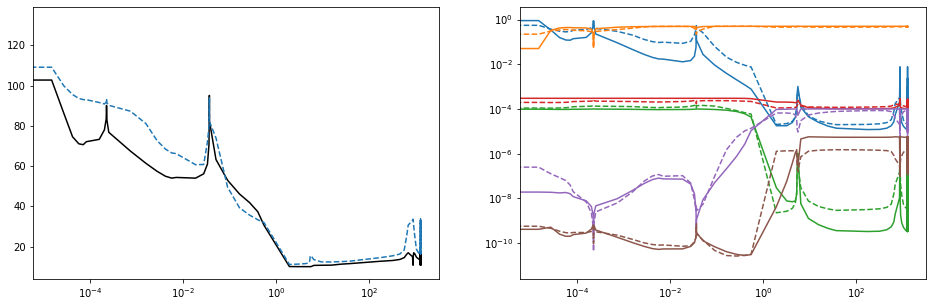

In [75]:
fig,[ax,ax2]=plt.subplots(1,2,figsize=(16,5))
ax.plot(uclpdr["Av"],uclpdr["T_g"],color="black")
ax.plot(uclpdr["Av"],output["gas_temp"],ls="--")
ax.set(xscale="log")

colors=sns.color_palette(n_colors=6)
for i,species in enumerate(["H","H2","C+","O","CO","H2O"]):
    ax2.plot(uclpdr["Av"],uclpdr[f"{species}_abun"],color=colors[i])
    ax2.plot(uclpdr["Av"],output[f"{species}"],ls="--",color=colors[i])

ax2.set(xscale="log",yscale="log")
